# Forecasting Lottery Numbers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.pyplot import figure
import seaborn as sns

In [3]:
df = pd.read_csv("powerball_numbers.csv")
print(f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

Dataset has 143 rows and 9 columns.


In [4]:
df.index=df['date']
df=df.drop(['date'], axis=1)

In [5]:
df=df.iloc[::-1]

In [6]:
df

,num1,num2,num3,num4,num5,num6,num7,num8
date,,,,,,,,
19/04/2018,9,5,32,13,33,4,25,7
26/04/2018,14,35,34,15,24,19,9,12
3/05/2018,19,20,6,1,24,3,16,13
10/05/2018,6,24,15,14,26,32,35,14
17/05/2018,9,26,16,34,3,31,25,9
...,...,...,...,...,...,...,...,...
10/12/2020,14,8,19,20,11,9,4,19
17/12/2020,29,4,17,16,33,5,9,13
24/12/2020,12,9,21,4,11,32,29,2


## Adding Analytical Figures

- Sequential Pairs (SP): denotes how many pairs of sequential numbers are there in a particular draw, e.g. the draw (10, 11, 20, 27, 28, 30, 31) has an SP of 3, being (10, 11), (27, 28) and (30, 31).
- Odd Even Ratio (OE): denotes the ratio of odd and even numbers in a draw, e.g. the draw (10, 11, 20, 27, 28, 30, 31) has an OE of 3:4, there are 3 odd numbers and 4 even numbers.
- Small Big Ratio (SB): denotes the ratio of numbers that belong to upper half and lower half, within the possible number range. e.g. PowerBall has a range of 1 to 35 for its main matrix, so let’s say Small range is 1-17 and Big range is 18-35, thus the draw (10, 11, 20, 27, 28, 30, 31) has a BS of 5:2
- Three Partition Ratio (3P): dividing the range of possible numbers into three partitions, for PowerBall, they are 1-12, 13-24 and 25-35, 3P denotes the number of balls that belong to each partition. For the draw (10, 11, 20, 27, 28, 30, 31), its 3P is 214.
- Head Tail Distance (HTD): the distance between the smallest number and the largest number in a single draw, for the draw (10, 11, 20, 27, 28, 30, 31), its HTD is 21.


- Arithmetic Complexity (AC): the complexity of a draw, it’s calculated in such a way:


1. Calculate the absolute difference between every two numbers in a draw.
2. Eliminate the same numbers from result of 1, let D be the remaining number of differences.
3. AC = D - (r - 1), r is the number of numbers in a draw

In [7]:
df['numString'] = df.values.tolist()

## Adding Sequential Pairs

In [8]:
sequential_pairs=[]

for prac in df['numString'].tolist():
    consec = []
    del prac[-1]
    for k in prac:
        for j in prac:
            if j==k:
                continue
            elif k+1==j or k-1==j:
                temp=[k,j]
                temp=tuple(sorted(temp))
                consec.append(temp)
    sequential_pairs.append(len(set(consec)))

In [9]:
df['SP']=sequential_pairs

### Adding Odd-Even Ratio

In [10]:
OE_list = []
for prac in df['numString'].tolist():
    even_count=0
    odd_count=0
    for k in prac:
        if k%2 ==0:
            even_count+=1
        else:
            odd_count+=1
    OE_ratio=odd_count/even_count
    OE_list.append(OE_ratio)

In [11]:
df['OE']=OE_list

### Adding Small-Big Ratio

In [12]:
SB_list = []
for prac in df['numString'].tolist():
    small_count=0
    big_count=0
    for k in prac:
        if k<18:
            small_count+=1
        else:
            big_count+=1
    try:
        SB_ratio=small_count/big_count
    except:
        SB_ratio=7
    SB_list.append(SB_ratio)

In [13]:
df['SB']=SB_list

### Adding 3-Partition Count

In [14]:
P1_list = []
P2_list = []
P3_list = []
for prac in df['numString'].tolist():
    small_count=0
    mid_count=0
    big_count=0
    for k in prac:
        if k<13:
            small_count+=1
        elif k>12 and k<25:
            mid_count+=1
        else:
            big_count+=1
    P1_list.append(small_count)
    P2_list.append(mid_count)
    P3_list.append(big_count)

In [15]:
df['P1']=P1_list
df['P2']=P2_list
df['P3']=P3_list

### Adding Head-Tail Distance

In [16]:
# df['HTD']=df['num7']-df['num1']

HTD_list = []
for prac in df['numString'].tolist():
    min_vals=min(prac)
    max_vals=max(prac)
    HTD_val=max_vals-min_vals
    HTD_list.append(HTD_val)

df['HTD']=HTD_list

### Adding Arithmetic Complexity

In [17]:
AC_list = []
for prac in df['numString'].tolist():
    diff_list = []
    for k in prac:
        for j in prac:
            if j==k:
                continue
            else:
                diff=abs(k-j)
                diff_list.append(diff)

    diff_list=set(diff_list)
    diff_length=len(diff_list)
    ac_value= diff_length-6
    AC_list.append(ac_value)

In [18]:
df['AC']=AC_list

In [19]:
df

,num1,num2,num3,num4,num5,num6,num7,num8,numString,SP,OE,SB,P1,P2,P3,HTD,AC
date,,,,,,,,,,,,,,,,,
19/04/2018,9,5,32,13,33,4,25,7,"[9, 5, 32, 13, 33, 4, 25]",2,2.500000,1.333333,3,1,3,29,10
26/04/2018,14,35,34,15,24,19,9,12,"[14, 35, 34, 15, 24, 19, 9]",2,1.333333,0.750000,1,4,2,26,8
3/05/2018,19,20,6,1,24,3,16,13,"[19, 20, 6, 1, 24, 3, 16]",1,0.750000,1.333333,3,4,0,23,10
10/05/2018,6,24,15,14,26,32,35,14,"[6, 24, 15, 14, 26, 32, 35]",1,0.400000,0.750000,1,3,3,29,9
17/05/2018,9,26,16,34,3,31,25,9,"[9, 26, 16, 34, 3, 31, 25]",1,1.333333,0.750000,2,1,4,31,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10/12/2020,14,8,19,20,11,9,4,19,"[14, 8, 19, 20, 11, 9, 4]",2,0.750000,2.500000,4,3,0,16,8
17/12/2020,29,4,17,16,33,5,9,13,"[29, 4, 17, 16, 33, 5, 9]",2,2.500000,2.500000,3,2,2,29,9
24/12/2020,12,9,21,4,11,32,29,2,"[12, 9, 21, 4, 11, 32, 29]",1,1.333333,1.333333,4,1,2,28,11


In [104]:
# sorted(df['num8'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [105]:
# sequential_pairs=[]
# prac=[4, 5, 9, 13, 25, 32, 33]

# AC_list = []
# diff_list = []
# for k in prac:
#     for j in prac:
#         if j==k:
#             continue
#         else:
#             diff=abs(k-j)
#             diff_list.append(diff)

# diff_list=set(diff_list)
# diff_length=len(diff_list)
# ac_value= diff_length-6
# AC_list.append(ac_value)

# AC_list



[10]

In [106]:
# len(np.where((df['num1'] == 1))[0])

#df['SP']=df[]

28

## Explorartory Data Analysis

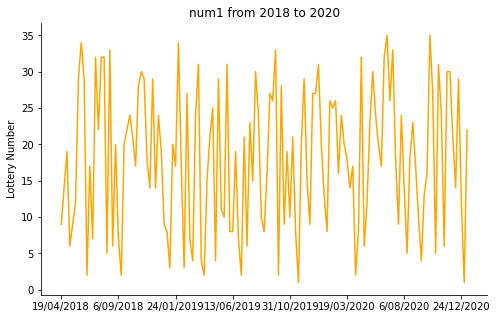

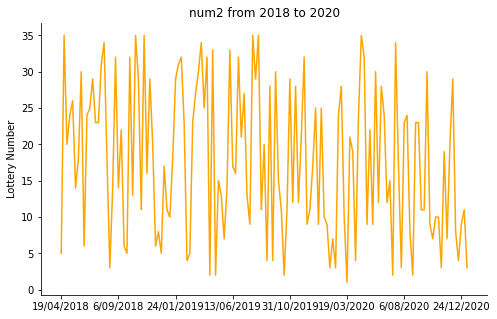

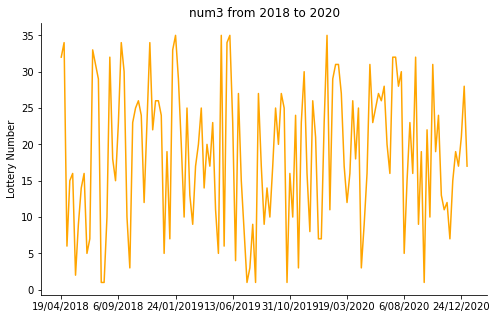

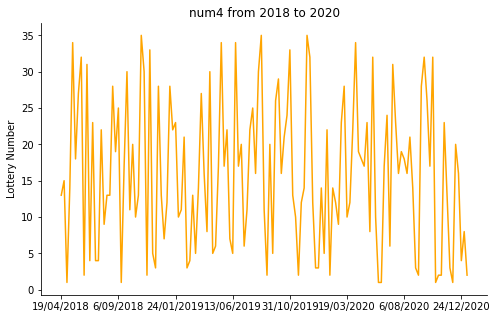

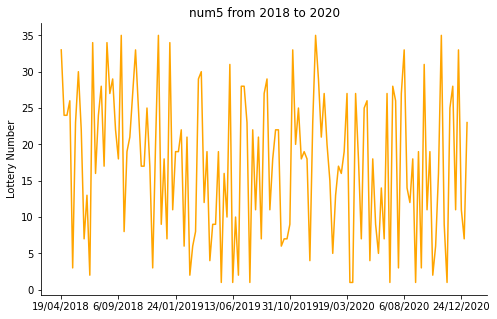

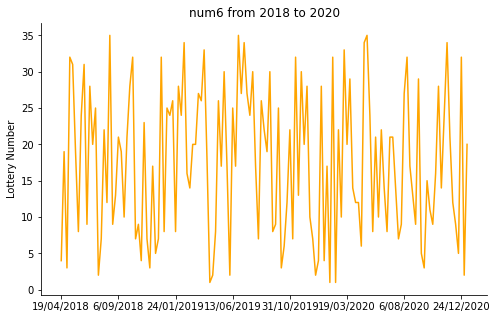

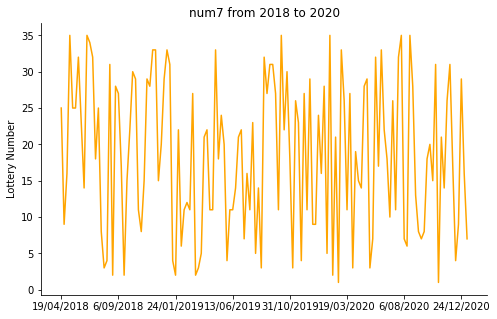

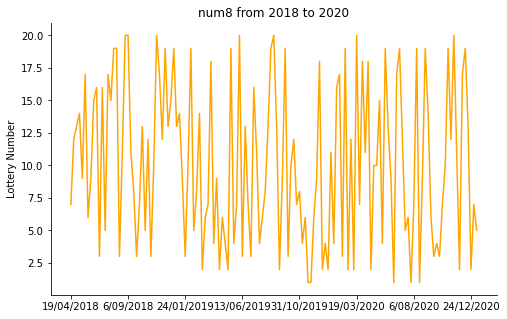

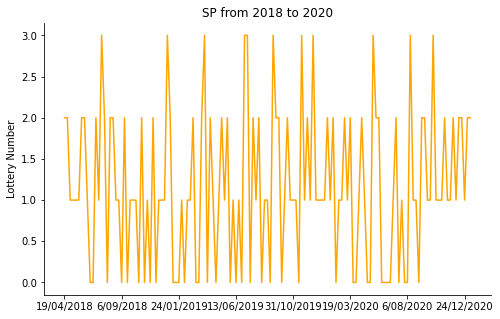

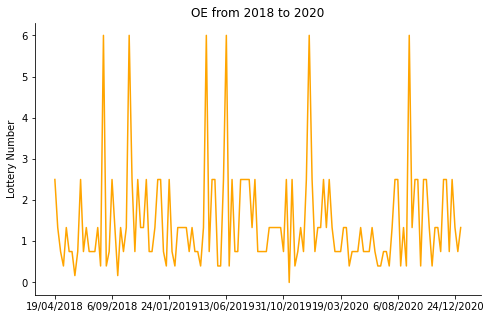

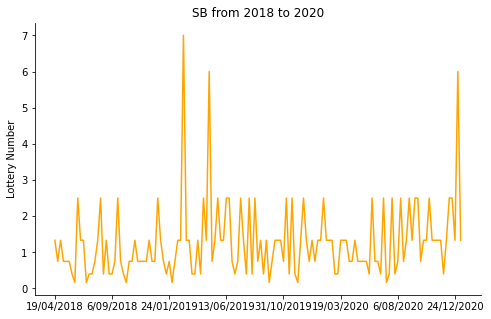

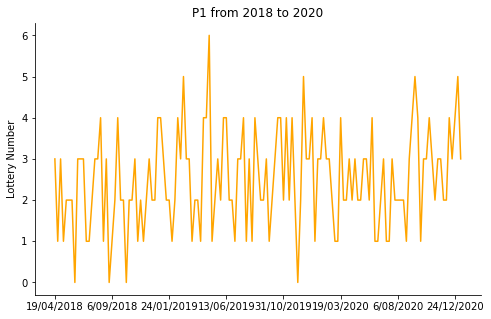

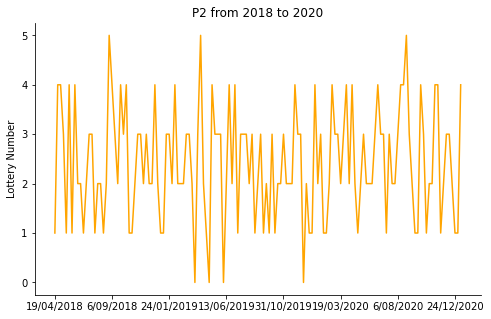

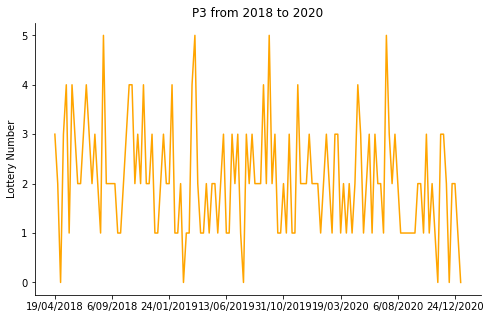

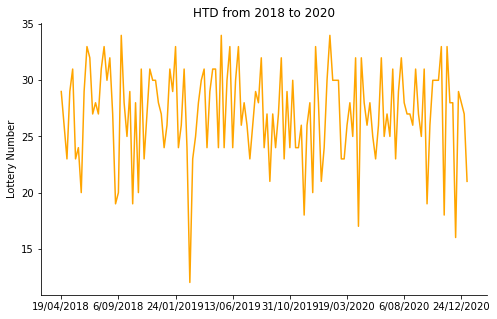

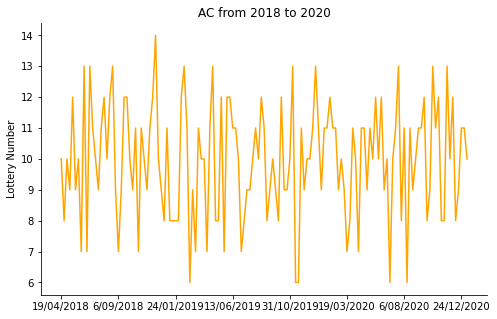

In [20]:
cols = ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'SP', 'OE', 'SB', 'P1', 'P2', 'P3', 'HTD', 'AC']

for i in cols:
    y=df[i]
    fig, ax= plt.subplots(figsize=(8,5))
    y.plot(color='orange')
    ax.set_xlabel('')
    ax.set_ylabel('Lottery Number')
    ax.set_title(f'{i} from 2018 to 2020')
    ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
    sns.despine()
    plt.show()

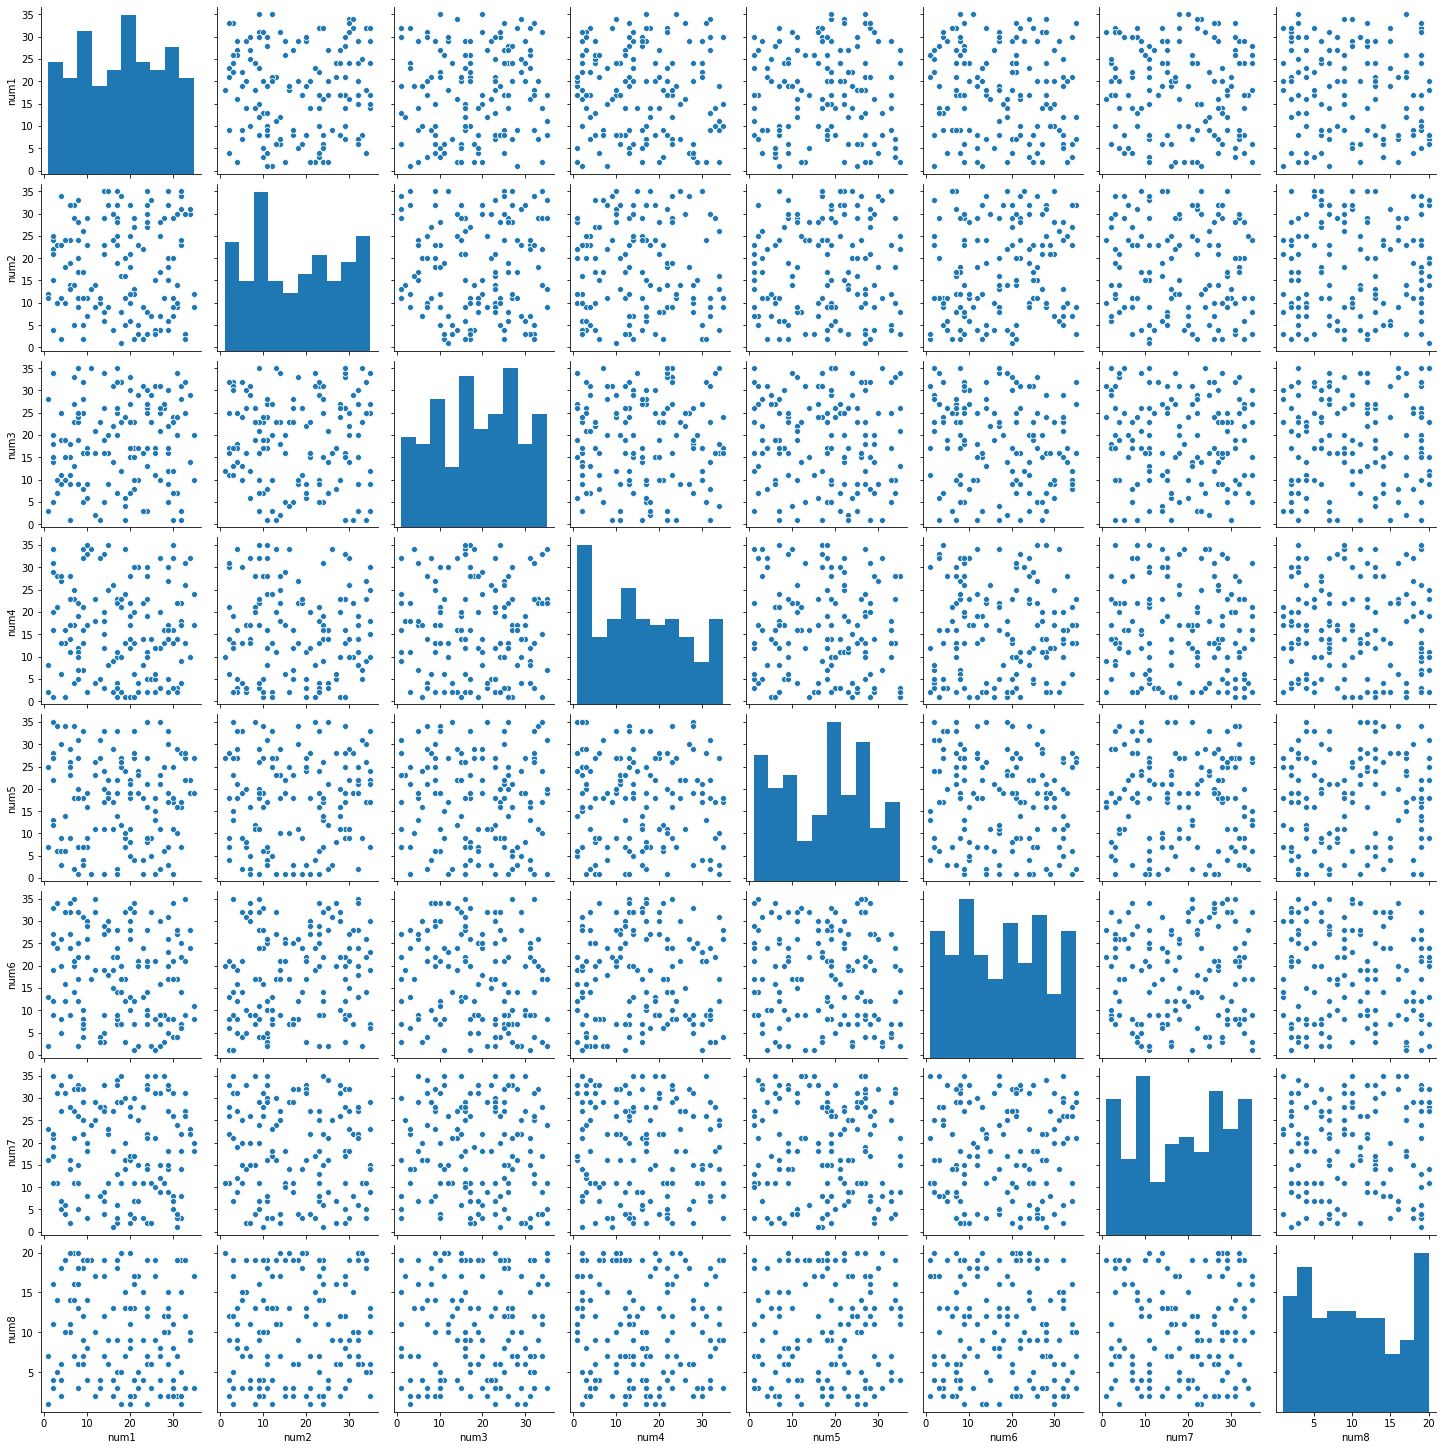

In [23]:
sns.pairplot(df,
            x_vars=['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8'],
            y_vars=['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8'],)

No correlation is apparent between the order of numbers that are drawn.

In [28]:
# from mpl_toolkits.mplot3d import axes3d

# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(df['num1'], df['num2'], df[['num3','num4']])
# plt.show()

## Assumption Checks

### Stationarity

In [29]:
# REFERENCE: https://towardsdatascience.com/simple-multivariate-time-series-forecasting-7fa0e05579b2

# Splitting the dataset into train & test subsets
n_obs = 120
df_train, df_test = df[:-n_obs], df[-(n_obs)+142:]

# Augmented Dickey-Fuller Test (ADF Test) to check for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(ds):
    dftest = adfuller(ds, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")


for i in cols:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_train[i])
    print('\n')

Column:  num1
--------------------------------------
Test Statistic          -1.687251
p-value                  0.437693
# Lags                   9.000000
# Observations          13.000000
Critical Value (1%)     -4.068854
Critical Value (5%)     -3.127149
Critical Value (10%)    -2.701730
dtype: float64

Series is Non-Stationary


Column:  num2
--------------------------------------
Test Statistic          -2.698749
p-value                  0.074255
# Lags                   7.000000
# Observations          15.000000
Critical Value (1%)     -3.964443
Critical Value (5%)     -3.084908
Critical Value (10%)    -2.681814
dtype: float64

Series is Non-Stationary


Column:  num3
--------------------------------------
Test Statistic          -1.574099
p-value                  0.496590
# Lags                   5.000000
# Observations          17.000000
Critical Value (1%)     -3.889266
Critical Value (5%)     -3.054358
Critical Value (10%)    -2.666984
dtype: float64

Series is Non-Stationary


Some of the features we intend to use in the model appear to be non-stationary and will be taken into consideration in the final conclusion of the results.

In [109]:
df_train=df_train.drop(['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8','numString'], axis=1)
df_test=df_test.drop(['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8','numString'], axis=1)

df_new=df.copy()
df_new=df_new.drop(['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8','numString'], axis=1)

## Modelling

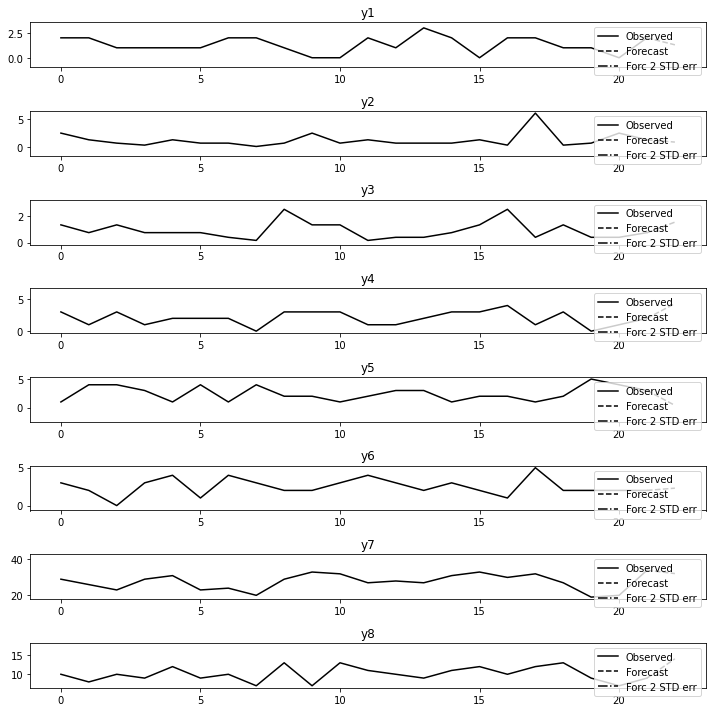

In [111]:
# Fitting the VAR model to the 2nd Differenced Data
from statsmodels.tsa.api import VAR

model = VAR(np.asarray(df_train))
results = model.fit()
results.summary()

# Forecasting for 100 steps ahead
lag_order = results.k_ar
predicted = results.forecast(df_train.values[-lag_order:], n_obs)
forecast = pd.DataFrame(predicted, index = df_new.index[-(n_obs)+142:], columns = df_new.columns)

# Plotting the Forecasted values
p1 = results.plot_forecast(1)
p1.tight_layout()

In [115]:
forecast

,SP,OE,SB,P1,P2,P3,HTD,AC
date,,,,,,,,
20/09/2018,1.297680,0.931300,1.538501,4.296467,0.403582,2.299951,32.143624,14.044348
27/09/2018,1.648640,0.898096,0.421586,1.033781,3.058612,2.907607,25.916753,9.024129
4/10/2018,1.281448,0.959630,1.002715,2.259625,2.442814,2.297561,27.153139,10.608243
11/10/2018,1.344676,1.206420,0.799968,1.745534,2.700015,2.554451,26.980036,9.684162
18/10/2018,1.281634,1.157187,0.950686,2.103699,2.466430,2.429871,27.652583,10.296284
...,...,...,...,...,...,...,...,...
3/12/2020,1.306429,1.166369,0.905329,2.017312,2.507225,2.475463,27.538675,10.156044
10/12/2020,1.306429,1.166369,0.905329,2.017312,2.507225,2.475463,27.538675,10.156044
17/12/2020,1.306429,1.166369,0.905329,2.017312,2.507225,2.475463,27.538675,10.156044


In [116]:
df_new

,SP,OE,SB,P1,P2,P3,HTD,AC
date,,,,,,,,
19/04/2018,2,2.500000,1.333333,3,1,3,29,10
26/04/2018,2,1.333333,0.750000,1,4,2,26,8
3/05/2018,1,0.750000,1.333333,3,4,0,23,10
10/05/2018,1,0.400000,0.750000,1,3,3,29,9
17/05/2018,1,1.333333,0.750000,2,1,4,31,12
...,...,...,...,...,...,...,...,...
3/12/2020,1,2.500000,1.333333,2,3,2,28,12
10/12/2020,2,0.750000,2.500000,4,3,0,16,8
17/12/2020,2,2.500000,2.500000,3,2,2,29,9


- need to fix that model returns integer values for some of the columns and that the ratios are those that make sense
- that means this is more of a classification problem than a time series model... consider this possibility and construct a classification model. - make dates as a label to the group where each date is formulated to be some category e.g. the 2nd lottery draw of the month March = (there are 52 periods that the lottery is on, since there are some months where 5 times a lottery is occured in a single month) therefore this value would be category 10 out of 52 - HOWEVER PROBLEM WITH THIS METHOD IS THAT THERE MAY NOT BE ENOUGH DATA CONSIDERING THIS... MAYBE TRY WITH USING MORE MONTHS THAT HAVE SMALLER DRAWS OF NUMBERS BUT THE PROBLEM THAT ARISES FROM THIS IS THAT THE DISTRIBUTION AND SELECTION OF DIFFERENT NUMBERS WILL BE DIFFERENT TO THAT OF THE CURRENT ONE, HENCE DIFFERENT PROBABILITIES AND DISTRIBUTIONS ARISE FROM DIFFERENT LOTTERY SELECTION